In [1]:
# Tipo de benchmark
processor = 'CPU'

In [2]:
# Definindo variáveis do treino
resolution = 256
batch = 64
steps_per_epoch = 15
epochs = 20

In [3]:
import os

# Definindo caminhos para o modelo e gráficos
caminho_base = f'C:/Python/Tarefas/Cats vs. Dogs/Benchmark/{processor}/res{resolution}_batch{batch}_steps{steps_per_epoch}_epochs{epochs}/'
os.makedirs(caminho_base, exist_ok=True)
caminho_modelo_salvo = f'{caminho_base}meu_modelo_GPU_res{resolution}_batch{batch}_steps{steps_per_epoch}_epochs{epochs}.keras'
caminho_grafico_acuracia_loss = f'{caminho_base}grafico_acuracia_loss{resolution}_batch{batch}_steps{steps_per_epoch}_epochs{epochs}.png'
caminho_tempo_treinamento = f'{caminho_base}tempo_treinamento_res{resolution}_batch{batch}_steps{steps_per_epoch}_epochs{epochs}.txt'
caminho_grafico_uso_CPU_GPU = f'{caminho_base}grafico_uso_cpu_gpu_res{resolution}_batch{batch}_steps{steps_per_epoch}_epochs{epochs}.png'

In [4]:
import tensorflow as tf

In [5]:
import keras as K

In [6]:
# Importar K e suas funções necessárias
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

In [7]:
# Inicializando a Rede Neural Convolucional
classifier = Sequential()

In [8]:
from tensorflow.keras.optimizers import Adam

# Adicionando a Primeira Camada de Convolução
classifier.add(Conv2D(32, (3, 3), input_shape = (resolution, resolution, 3), activation = 'relu'))

# Pooling
classifier.add(MaxPooling2D(pool_size = (4, 4)))

# Adicionando a Segunda Camada de Convolução
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))

# Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Convolução mais complexa
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adicionando Dropout
classifier.add(Dropout(0.1))

# Flattening - Transformando em 1D
classifier.add(Flatten())

# Full connection
classifier.add(Dense(units = resolution, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compilando a rede
classifier.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Criar o objeto com as regras de pré-processamento
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   width_shift_range=0.2,  # Deslocamento horizontal
                                   height_shift_range=0.2)  # Deslocamento vertical)

In [10]:
# Pré-processamento das imagens de treino
training_set = train_datagen.flow_from_directory('C:/Users/peter/OneDrive/Trabalhos/2024/Tópicos em Engenharia da Computação/dogs-vs-cats/train',
                                                 target_size = (resolution, resolution),
                                                 batch_size = batch,
                                                 class_mode = 'binary')

Found 25000 images belonging to 2 classes.


Epoch 1/20
15/15 [==============================] - 29s 2s/step - loss: 0.7010 - accuracy: 0.5125
Epoch 2/20
15/15 [==============================] - 27s 2s/step - loss: 0.6998 - accuracy: 0.4990
Epoch 3/20
15/15 [==============================] - 27s 2s/step - loss: 0.6879 - accuracy: 0.5813
Epoch 4/20
15/15 [==============================] - 27s 2s/step - loss: 0.6846 - accuracy: 0.5250
Epoch 5/20
15/15 [==============================] - 27s 2s/step - loss: 0.6837 - accuracy: 0.5240
Epoch 6/20
15/15 [==============================] - 27s 2s/step - loss: 0.6755 - accuracy: 0.5781
Epoch 7/20
15/15 [==============================] - 27s 2s/step - loss: 0.6652 - accuracy: 0.6240
Epoch 8/20
15/15 [==============================] - 26s 2s/step - loss: 0.6517 - accuracy: 0.6197
Epoch 9/20
15/15 [==============================] - 27s 2s/step - loss: 0.6564 - accuracy: 0.5969
Epoch 10/20
15/15 [==============================] - 27s 2s/step - loss: 0.6414 - accuracy: 0.6333
Epoch 11/20
15/15 [

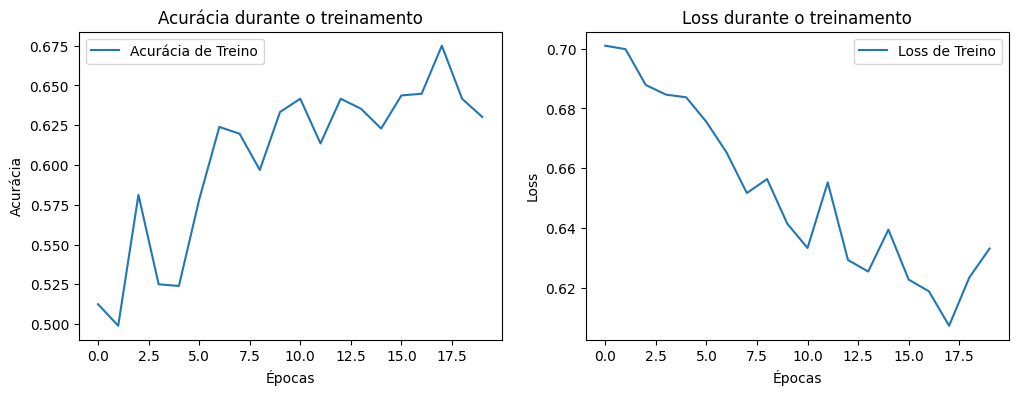

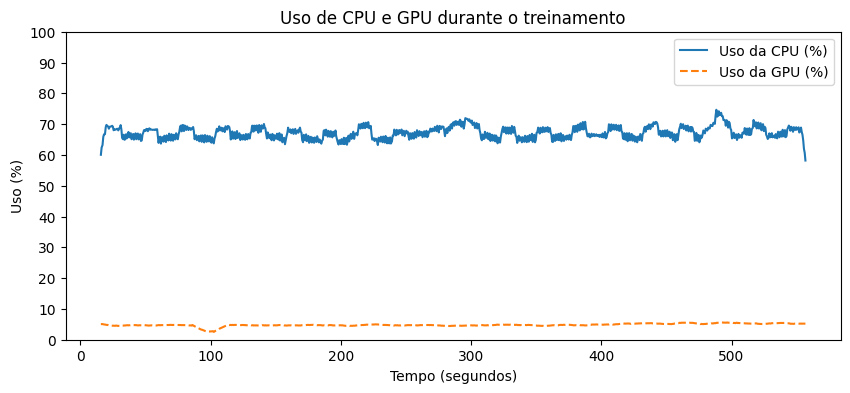

Tempo total de treinamento: 554.14 segundos


In [11]:
import matplotlib.pyplot as plt
import psutil
import time
import GPUtil
import numpy as np
from threading import Thread

# Função para monitorar CPU e GPU
cpu_usage = []
gpu_usage = []
timestamps = []

def monitor_usage(interval=0.5):
    while True:
        cpu_usage.append(psutil.cpu_percent())
        gpus = GPUtil.getGPUs()
        if gpus:
            gpu_usage.append(gpus[0].load * 100)
        else:
            gpu_usage.append(0)  # Se não houver GPU disponível
        timestamps.append(time.time())
        time.sleep(interval)

# Iniciando o monitoramento de CPU e GPU em uma thread separada
monitor_thread = Thread(target=monitor_usage, daemon=True)
monitor_thread.start()

# Medindo o tempo de treinamento
start_time = time.time()

# Faz o modelo
history = classifier.fit(training_set,
                             batch_size=batch,
                             steps_per_epoch=steps_per_epoch,
                             epochs=epochs)

# Calculando o tempo gasto no treinamento
end_time = time.time()
tempo_treinamento = end_time - start_time

# Salvando o modelo
classifier.save(caminho_modelo_salvo)
print(f"\nModelo treinado e salvo em: {caminho_modelo_salvo}")

# Salvando o tempo de treinamento em um arquivo de texto
with open(caminho_tempo_treinamento, 'w') as file:
    file.write(f"Tempo total de treinamento: {tempo_treinamento:.2f} segundos\n")

# Plotando os gráficos de accuracy e loss
plt.figure(figsize=(12, 4))
# Gráfico de Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.title('Acurácia durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
# Gráfico de Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss de Treino')
plt.title('Loss durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
# Salvando o gráfico de acurácia e loss
plt.savefig(caminho_grafico_acuracia_loss)
print("\n")
plt.show()

# Espera um pouco para garantir que todos os dados de uso foram coletados
time.sleep(2)

def truncate_lists():
    # Encontra o tamanho mínimo entre as listas
    min_len = min(len(timestamps), len(cpu_usage), len(gpu_usage))
    
    # Trunca todas as listas para o tamanho mínimo
    return timestamps[:min_len], cpu_usage[:min_len], gpu_usage[:min_len]
# Após coletar os dados, aplique a média móvel
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Ajustar os timestamps para começar em 0
timestamps = [t - timestamps[0] for t in timestamps]  # Subtrair o primeiro timestamp
# Truncar as listas antes de plotar
timestamps, cpu_usage, gpu_usage = truncate_lists()
# Calcular o tempo total de execução
total_time = timestamps[-1]  # Último timestamp
# Definir o tamanho da janela baseado no tempo total (5% do tempo total)
window_size = max(1, int(total_time / 20))  # Pelo menos 1 para evitar divisão por zero
# Suavizar os dados
cpu_usage_smooth = moving_average(cpu_usage, window_size)
gpu_usage_smooth = moving_average(gpu_usage, window_size)
# Ajustar os timestamps para a média móvel
timestamps_smooth = timestamps[window_size - 1:]  # Ajustar para a média móvel

# Plotando gráfico de uso de CPU e GPU
plt.figure(figsize=(10, 4))
plt.plot(timestamps_smooth, cpu_usage_smooth, label='Uso da CPU (%)')
plt.plot(timestamps_smooth, gpu_usage_smooth, label='Uso da GPU (%)', linestyle='--')
plt.xlabel('Tempo (segundos)')
plt.ylabel('Uso (%)')
plt.title('Uso de CPU e GPU durante o treinamento')
plt.legend(loc='upper right')
# Definir o limite do eixo Y entre 0 e 100%
plt.ylim(0, 100)
# Aumentar o número de ticks no eixo Y
plt.yticks(np.arange(0, 101, 10))
# Salvando o gráfico de uso de CPU e GPU
plt.savefig(caminho_grafico_uso_CPU_GPU)
plt.show()

# Exibir o tempo de treinamento no console
print(f"Tempo total de treinamento: {tempo_treinamento:.2f} segundos")

1/1 [==============================] - 0s 144ms/step
Valor bruto: [[0.47327995]]
Previsão: Gato.
Acurácia: 52.67 %.


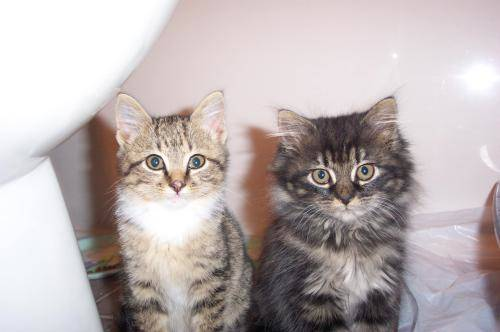

In [12]:
import numpy as np
from keras.preprocessing import image
from IPython.display import Image

caminho_imagem = 'C:/Users/peter/OneDrive/Trabalhos/2024/Tópicos em Engenharia da Computação/dogs-vs-cats/test1/test1/2133.jpg'

# Carregando a imagem de teste
test_image = image.load_img(caminho_imagem, target_size=(resolution, resolution))
test_image = image.img_to_array(test_image) / 255
test_image = np.expand_dims(test_image, axis=0)

# Fazendo a previsão usando o modelo classifier
result = classifier.predict(test_image)
class_indices = training_set.class_indices

print("Valor bruto:", result)

if result[0][0] >= 0.5:
    prediction = 'Cachorro.'
    accuracy = round(result[0][0] * 100, 2)  # A saída de previsão é uma probabilidade entre 0 e 1
else:
    prediction = 'Gato.'
    accuracy = round((1 - result[0][0]) * 100, 2)  # A saída de previsão é uma probabilidade entre 0 e 1

# Exibindo a previsão e a acurácia
print("Previsão:", prediction)
print("Acurácia:", accuracy, "%.")

# Exibindo a imagem
Image(filename=caminho_imagem)
